# Imports

In [1]:
import numpy as np
import pandas as pd
import os

from skimage.transform import resize   # Image Processing Library
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc    # Garbage Collector
gc.collect()

import random

import os

# Pytorch

import sklearn

import torch
import torchvision

from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange

import PIL

In [2]:
# Input data files (dogs_and_cats) are available in the "../data/dogs_and_cats/" directory.
print(os.listdir("../data/dogs_and_cats"))

['annotations', 'images']


# Data Preprocessing

In [3]:
img_dir = "../data/dogs_and_cats/images/"
annotations_dir = "../data/dogs_and_cats/annotations/"

In [4]:
img_dir

'../data/dogs_and_cats/images/'

In [5]:
os.listdir(img_dir)[0]

'Abyssinian_1.jpg'

In [6]:
img_path = os.path.join(img_dir, os.listdir(img_dir)[0])
img_path

'../data/dogs_and_cats/images/Abyssinian_1.jpg'

In [7]:
test_image = read_image(img_path)

In [8]:
test_image.shape

torch.Size([3, 128, 128])

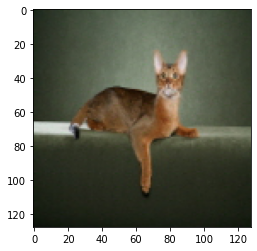

In [9]:
plt.imshow(test_image.permute(1, 2, 0));

In [10]:
def thresh(x):
    if x < 0.5:
        return 0
    else:
        return 1
    
thresh = np.vectorize(thresh, otypes=[float]) 

In [11]:
# Class for Datasets using Custom Images

class CustomImageDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None, target_transform=None):
        self.annotations_dir = annotations_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        PIL_img = PIL.Image.open(img_path)
        image = ToTensor()(PIL_img)
        image = image[0].unsqueeze(0)
        annotation_path = os.path.join(self.annotations_dir, os.listdir(self.annotations_dir)[idx])
        PIL_annotation = PIL.Image.open(annotation_path)
        annotation = ToTensor()(PIL_annotation)
        annotation = annotation[0].unsqueeze(0)
        annotation = np.transpose(thresh(annotation), (2, 0, 1))
        annotation = ToTensor()(annotation).permute(2, 0, 1)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            annotation = self.target_transform(annotation)
        return image, annotation

In [12]:
dataset = CustomImageDataset(
    annotations_dir, 
    img_dir,
    # transform=ToTensor(),          -> Gives Error
    # target_transform=ToTensor()    -> Gives Error
)

In [13]:
test_img, test_annot = dataset[0]

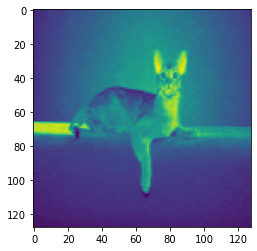

In [14]:
plt.imshow(test_img.permute(1, 2, 0));

In [15]:
test_annot.shape

torch.Size([1, 128, 128])

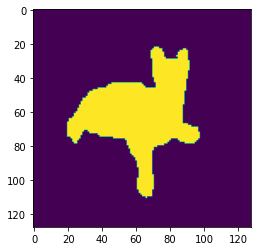

In [16]:
plt.imshow(test_annot.permute(1, 2, 0));

In [17]:
len(dataset)

7390

# Preparation of Train / Test DataLoader

In [18]:
BATCH_SIZE = 10
TEST_SPLIT = 0.1
VALIDATION_SPLIT = 0.2
SHUFFLE_DATASET = True
RANDOM_SEED = 42
WIDTH = 128
HEIGHT = 128

In [19]:
# Train/Test Split

dataset_size = len(dataset)
indices = list(range(dataset_size))
test_split = int(np.floor(TEST_SPLIT * dataset_size) + 1)   # To match train/valid/test divisible by 10
if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = indices[test_split:], indices[:test_split]

# Train/Validation Split
train_size = len(train_indices)
valid_split = int(np.floor(VALIDATION_SPLIT * train_size))
if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(train_indices)
train_indices, val_indices = train_indices[valid_split:], train_indices[:valid_split]


# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, 
                          sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=BATCH_SIZE,
                          sampler=valid_sampler)
test_loader = DataLoader(dataset, batch_size=1,
                         sampler=valid_sampler)

In [20]:
len(train_sampler)

5320

In [21]:
len(valid_sampler)

1330

In [22]:
len(test_sampler)

740

In [23]:
# Sample Image and Annotation

sample_img, sample_annot = next(iter(train_loader))

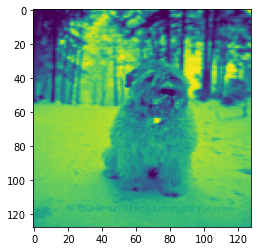

In [24]:
plt.imshow(sample_img[0].squeeze());

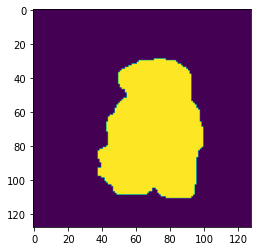

In [25]:
plt.imshow(sample_annot[0].squeeze());

# Unet Setup

In [26]:
use_gpu = torch.cuda.is_available()

In [27]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, 
                                     out_channels=out_channels, 
                                     kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
        )
        return block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            # torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=256, padding=1),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm2d(512),
            torch.nn.BatchNorm2d(256),
            # torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
            torch.nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2   # Calculate by how much the bypass should be decreased
            bypass = F.pad(bypass, (-c, -c, -c, -c))   # Reduces the bypass by padding -c
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        # print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        # print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        # print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        # print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        # print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        # print(final_layer.shape)
        return final_layer

# Model Training

In [28]:
learning_rate = 0.01
unet = UNet(in_channel=1, out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr=learning_rate, momentum=0.99)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        train_batch_acc = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            X = X.float()
            X = X.to(device)
            y = y.type(torch.LongTensor)
            y = y.to(device)
            y = y.permute(0, 2, 3, 1)
            y = y.resize(BATCH_SIZE*WIDTH*HEIGHT)
            y_hat = model(X)  # forward pass to get output
            y_hat = y_hat.permute(0, 2, 3, 1)
            y_hat = y_hat.resize(BATCH_SIZE*WIDTH*HEIGHT, 2)
            # _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += ((y_hat[:, 1]>0.5).int() == y).type(torch.float32).mean()#.item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                X = X.float()
                X = X.to(device)
                y = y.type(torch.LongTensor)
                y = y.to(device)
                y = y.permute(0, 2, 3, 1)
                y = y.resize(BATCH_SIZE*WIDTH*HEIGHT)
                y_hat = model(X)  # forward pass to get output
                y_hat = y_hat.permute(0, 2, 3, 1)
                y_hat = y_hat.resize(BATCH_SIZE*WIDTH*HEIGHT, 2)
                # _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += ((y_hat[:, 1]>0.5).int() == y).type(torch.float32).mean()#.item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.7f}.",
                  f"Valid Loss: {valid_loss[-1]:.7f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}."
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}."
                 )
            
    print("\nTraining ended.")
    
    return train_loss, valid_loss, train_accuracy, valid_accuracy

In [31]:
%%time

train_loss, valid_loss, train_accuracy, valid_accuracy = trainer(
    unet, criterion, optimizer, train_loader, valid_loader, epochs=30, verbose=True
)

C:\Users\johnw\miniconda3\envs\575\lib\site-packages\torch\_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 1: Train Loss: 0.4959946. Valid Loss: 0.5466873. Train Accuracy: 0.73.Valid Accuracy: 0.77.

Training ended.
CPU times: total: 35min 29s
Wall time: 6min 15s


In [45]:
train_accuracy[0].cpu().numpy()

array(0.73470455, dtype=float32)

In [48]:
valid_accuracy[0].cpu().numpy().tolist()

0.7731578946113586

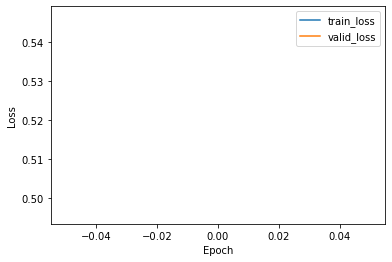

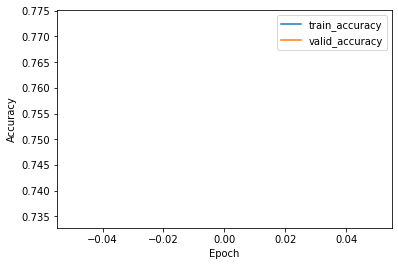

In [50]:
loss_fig = pd.DataFrame(
    {"train_loss": train_loss, "valid_loss": valid_loss}
).plot.line()
loss_fig.set_xlabel('Epoch')
loss_fig.set_ylabel('Loss');

accur_fig = pd.DataFrame(
    {"train_accuracy": [train_accuracy[0].cpu().numpy().tolist()], 
     "valid_accuracy": [valid_accuracy[0].cpu().numpy().tolist()]}
).plot.line()
accur_fig.set_xlabel('Epoch')
accur_fig.set_ylabel('Accuracy');

In [ ]:
X_test, y_test = next(iter(test_loader))

In [ ]:
X_test.shape

In [ ]:
plt.imshow(np.array(X_test.squeeze().cpu()));

In [ ]:
X_test = X_test.to(device)
y_hat = unet(X_test)

In [ ]:
y_hat.shape

In [ ]:
plt.imshow(np.array(y_hat.squeeze()[0].detach().cpu()));

In [ ]:
plt.imshow(np.array(y_hat.squeeze()[1].detach().cpu()));

In [ ]:
plt.imshow(np.array(y_test.squeeze().cpu()));

In [ ]:
y_hat_test = thresh(y_hat.detach().cpu())

In [ ]:
plt.imshow(y_hat_test.squeeze()[0]);

In [ ]:
plt.imshow(y_hat_test.squeeze()[1]);

In [ ]:
(np.array(y_test.squeeze().cpu()) == y_hat_test.squeeze()[1]).mean()

In [ ]:
X, y = next(iter(train_loader))

# X = X.float()
# X = X.to(device)
# y = y.type(torch.LongTensor)
# y = y.to(device)
# y = y.permute(0, 2, 3, 1)
# y = y.resize(BATCH_SIZE*WIDTH*HEIGHT)
# y_hat = model(X)  # forward pass to get output
# y_hat = y_hat.permute(0, 2, 3, 1)



In [ ]:
y.shape

In [ ]:
y = y.permute(0, 2, 3, 1)

In [ ]:
X, y = next(iter(train_loader))
X = X.float()
X = X.to(device)
y = y.to(device)
# y_hat = unet(X)

In [ ]:
y_hat = unet(X)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)  
    labels = labels.resize(batch_size*width_out*height_out)   # Resize to 1D
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [ ]:
batch_size = 9
epochs = 1000
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [ ]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)  # Calculate # of iteration based on batch size
t = trange(epochs, leave=True)   # leave=True : leaves progress bar upon termination of iteration
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

In [ ]:
gc.collect()

# Evaluation

In [ ]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

In [ ]:
plot_examples(x_train, y_train)

In [ ]:
plot_examples(x_val, y_val)

In [ ]:
torch.save(unet.state_dict(), 'unet.pt')